### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
# from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("data/webinar_5/churn_data.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X [self.columns]

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Зададим списки признаков

In [7]:
# base_columns = ['HasCrCard', 'IsActiveMember']
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [8]:
gender = Pipeline([
                ('selector', FeatureSelector(column='HasCrCard')),
                ('ohe', OHEEncoder(key='HasCrCard'))
            ])
gender.fit(X_train)
gender.transform(X_test).head()

,HasCrCard_0,HasCrCard_1
9394,0,1
898,0,1
2398,0,1
5906,1,0
2343,0,1


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

# for base_col in base_columns:
#     base_transformer = Pipeline([
#                 ('selector', NumberSelector(key=cont_col)),
#             ])
#     final_transformers.append((base_col, base_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaller', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модели

In [11]:
pipeline_lr = Pipeline([
    ('features',feats),
    ('lr_classifier', LogisticRegression()),
])

pipeline_rf = Pipeline([
    ('features',feats),
    ('rf_classifier', RandomForestClassifier(random_state = 42)),
])

pipeline_gb = Pipeline([
    ('features',feats),
    ('gb_classifier', GradientBoostingClassifier(random_state = 42)),
])

Обучим модель

In [12]:
#обучим наш пайплайн
pipeline_lr.fit(X_train, y_train); pipeline_rf.fit(X_train, y_train); pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [13]:
#наши прогнозы для тестовой выборки
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]
preds_lr[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [14]:
#наши прогнозы для тестовой выборки
preds_rf = pipeline_rf.predict_proba(X_test)[:, 1]
preds_rf[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [15]:
#наши прогнозы для тестовой выборки
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]
preds_gb[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [16]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, preds_lr)

fscore_lr = (2 * precision_lr * recall_lr) / (precision_lr + recall_lr)
# locate the index of the largest f score
ix_lr = np.argmax(fscore_lr)
print('Best for LogisticRegression - Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (thresholds_lr[ix_lr],
                                                                                                 fscore_lr[ix_lr],
                                                                                                 precision_lr[ix_lr],
                                                                                                 recall_lr[ix_lr],
                                                                                                 roc_auc_score(y_test, preds_lr)))

Best for LogisticRegression - Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568, Roc-AUC=0.772


In [17]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, preds_rf)

fscore_rf = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
# locate the index of the largest f score
ix_rf = np.argmax(fscore_rf)
print('Best for RandomForestClassifier - Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (thresholds_rf[ix_rf],
                                                                                                 fscore_rf[ix_rf],
                                                                                                 precision_rf[ix_rf],
                                                                                                 recall_rf[ix_rf],
                                                                                                 roc_auc_score(y_test, preds_rf)))

Best for RandomForestClassifier - Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629, Roc-AUC=0.864


In [18]:
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, preds_gb)

fscore_gb = (2 * precision_gb * recall_gb) / (precision_gb + recall_gb)
# locate the index of the largest f score
ix_gb = np.argmax(fscore_gb)
print('Best for GradientBoostingClassifier - Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (thresholds_gb[ix_gb],
                                                                                                 fscore_gb[ix_gb],
                                                                                                 precision_gb[ix_gb],
                                                                                                 recall_gb[ix_gb],
                                                                                                 roc_auc_score(y_test, preds_gb)))

Best for GradientBoostingClassifier - Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597, Roc-AUC=0.876


Отрисуем матрицу ошибок

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


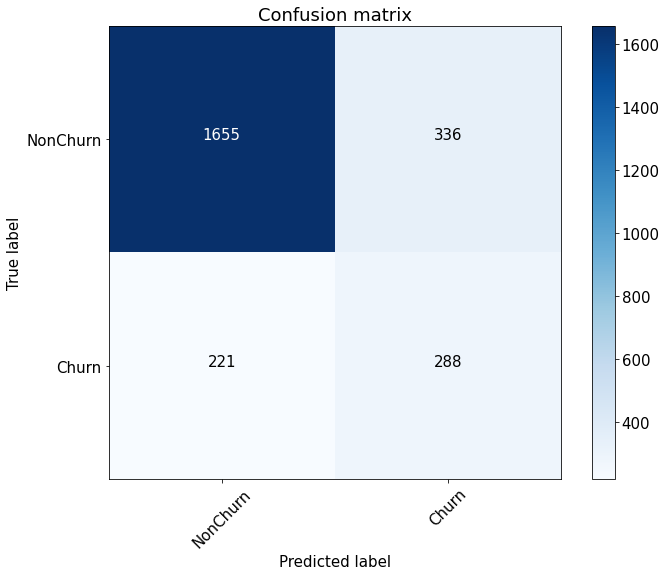

In [20]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, preds_lr>thresholds_lr[ix_lr])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_lr, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix');
# plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


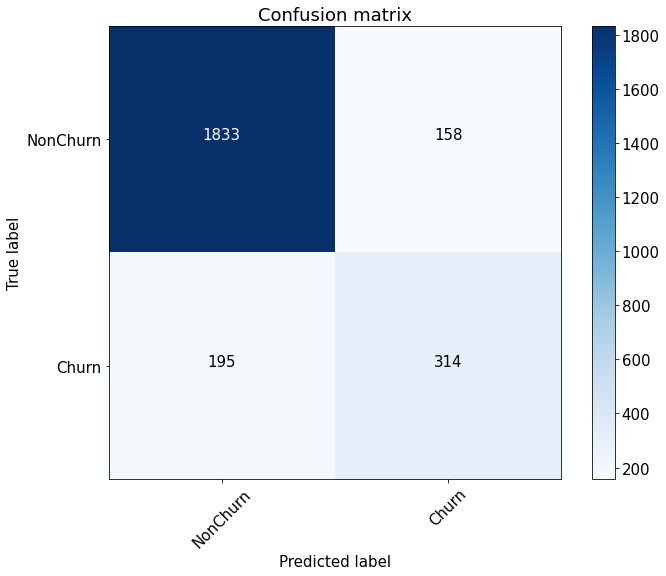

In [21]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, preds_rf>thresholds_rf[ix_rf])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


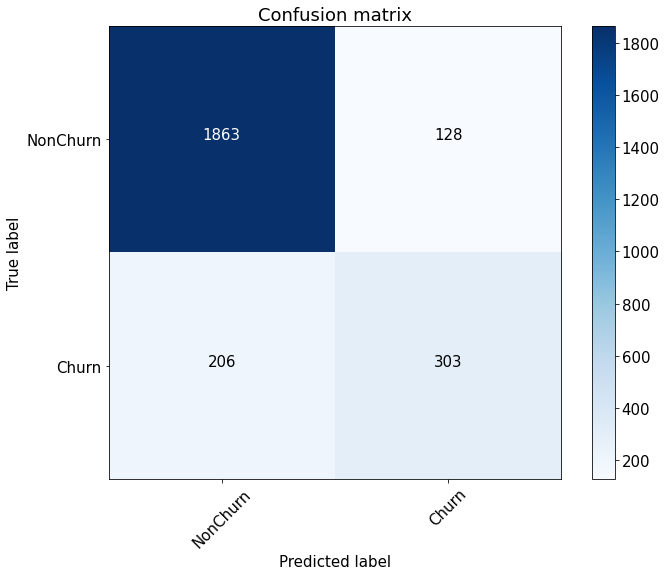

In [22]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, preds_gb>thresholds_gb[ix_gb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR для LogisticRegression

In [23]:
TN = cnf_matrix_lr[0][0]
FN = cnf_matrix_lr[1][0]
TP = cnf_matrix_lr[1][1]
FP = cnf_matrix_lr[0][1]

TPR_lr = TP/(TP+FN)
FPR_lr = FP/(FP+TN)
TNR_lr = TN/(FP+TN)
TPR_lr, FPR_lr, TNR_lr

(0.5658153241650294, 0.1687594173782019, 0.8312405826217981)

Посчитаем FPR, TPR для RandomForestClassifier

In [24]:
TN = cnf_matrix_rf[0][0]
FN = cnf_matrix_rf[1][0]
TP = cnf_matrix_rf[1][1]
FP = cnf_matrix_rf[0][1]

TPR_rf = TP/(TP+FN)
FPR_rf = FP/(FP+TN)
TNR_rf = TN/(FP+TN)
TPR_rf, FPR_rf, TNR_rf

(0.6168958742632613, 0.07935710698141638, 0.9206428930185836)

Посчитаем FPR, TPR для GradientBoostingClassifier

In [25]:
TN = cnf_matrix_gb[0][0]
FN = cnf_matrix_gb[1][0]
TP = cnf_matrix_gb[1][1]
FP = cnf_matrix_gb[0][1]

TPR_gb = TP/(TP+FN)
FPR_gb = FP/(FP+TN)
TNR_gb = TN/(FP+TN)
TPR_gb, FPR_gb, TNR_gb

(0.5952848722986247, 0.06428930185836264, 0.9357106981416373)

Оценим экономические эффективности полученных моделей:
 - LR: 1`$` * (TP + FP) - 2`$` * TP = 1`$` * (288 + 336) - 2`$` * 288 = -48`$` - имеем убытки
 
 - RF: 1`$` * (TP + FP) - 2`$` * TP = 1`$` * (314 + 158) - 2`$` * 314 = +156`$` - имеем прибыль
 
 - GB: 1`$` * (TP + FP) - 2`$` * TP = 1`$` * (303 + 128) - 2`$` * 303 = +175`$` - имеем максимальную прибыль из трёх вариантов

Выполним подбор гиперпараметров для GradientBoostingClassifier

In [38]:
params={'gb_classifier__n_estimators': [90, 110, 130],
        'gb_classifier__max_features': [0.2, 0.3, 0.4],
        'gb_classifier__min_samples_leaf': [1, 2, 3],
        'gb_classifier__max_depth': [3, 5, 7]
        }

In [39]:
grid = GridSearchCV(pipeline_gb,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'gb_classifier__max_depth': 5,
 'gb_classifier__max_features': 0.3,
 'gb_classifier__min_samples_leaf': 1,
 'gb_classifier__n_estimators': 110}

Обучаем модель уже с новыми параметрами

In [138]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(
        n_estimators=110,
#         max_depth=3, # default=3
#         max_features=0.3, # default=None
#         min_samples_leaf=1, # default=1
        random_state=42
    )),
])
pipeline.fit(X_train, y_train);

Best Threshold=0.409371, F-Score=0.646, Precision=0.706, Recall=0.595
Confusion matrix, without normalization
[[1865  126]
 [ 207  302]]


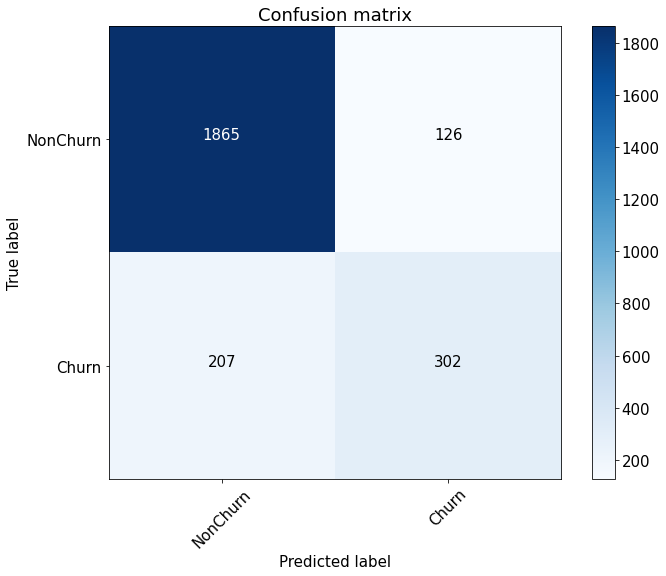

In [139]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Заключение:
    Модель на основе "GradientBoostingClassifier" улучшить не удалось (экономика, соответственно, тоже).

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

1. Вспоминая перевод данных терминов, Precision - "точность", Recall - "полнота", а также график ROC-кривой и алгоритм её построения, изменение порога вероятности в ту или другую сторону вызовет их взаимопротивоположные изменения.

2, 3. Ответ - да, но цена этого будет такой, что Precision будет стремиться к нулю. Аналогично обратная ситуация.

#### Вопрос 2:
Предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?

Ваш ответ здесь: 

Расчёт выполнен в рамках домашнего задания.